Train data shape: (50000, 32, 32, 3)
Input shape: [32, 32, 3]
Tensor("downLayer0/MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("downLayer1/MaxPool:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("downLayer2/MaxPool:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("upLayer2/Relu:0", shape=(64, 8, 8, 64), dtype=float32)
Tensor("upLayer1/Relu:0", shape=(64, 16, 16, 32), dtype=float32)
Tensor("upLayer0/Relu:0", shape=(64, 32, 32, 3), dtype=float32)
Iteration:  0  Loss:  121.041504
Iteration:  100  Loss:  69.11886
Iteration:  200  Loss:  39.338993
Iteration:  300  Loss:  32.34801
Iteration:  400  Loss:  30.527216
Iteration:  500  Loss:  27.45711
Iteration:  600  Loss:  25.256727
Iteration:  700  Loss:  23.566137
Iteration:  800  Loss:  23.219053
Iteration:  900  Loss:  22.803085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test whats up:
First test loss:  21.988039
Second test loss:  22.302858


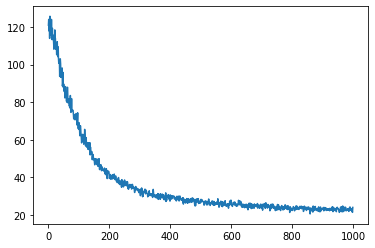

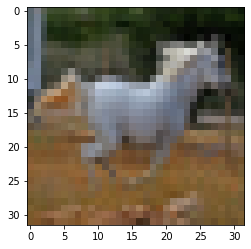

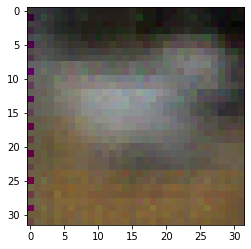

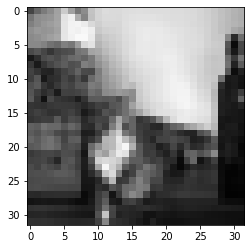

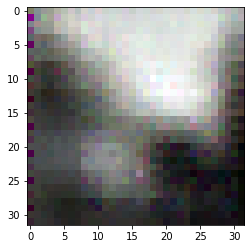

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%tensorflow_version 1.x

from keras.datasets import cifar10
(train_data, train_label), (test_data, test_label) = cifar10.load_data()

print("Train data shape:", train_data.shape)

input_size = [32, 32, 3]

print("Input shape:", input_size)

num_kernels = [input_size[-1], 32, 64, 128]

losses = list()

num_iterations = 1000
batch_size = 64
learning_rate = 1e-4

weights = []
img_sizes = []

tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None] + input_size)

current_input = input_data

for i in range(len(num_kernels)-1):
  with tf.variable_scope("downLayer" + str(i)):
    w = tf.get_variable('w', [3, 3, num_kernels[i], num_kernels[i+1]])
    weights.append(w)
    b = tf.get_variable('b', [num_kernels[i+1]])
    current_input = tf.nn.conv2d(current_input, filter = w, strides = [1, 1, 1, 1], padding = "SAME")
    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)
    img_sizes.append([current_input.shape[1], current_input.shape[2]])
    current_input = tf.nn.max_pool(current_input, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
    print(current_input)

for i in range(len(num_kernels)-2, -1, -1):
  with tf.variable_scope("upLayer" + str(i)):
    w = weights[i]
    b = tf.get_variable('b', [num_kernels[i]])
    current_input = tf.nn.conv2d_transpose(current_input, filters = w, output_shape = [batch_size, img_sizes[i][0], img_sizes[i][1], num_kernels[i]], strides = [1, 2, 2, 1], padding = "SAME")
    current_input = tf.add(current_input, b)
    current_input = tf.nn.relu(current_input)
    print(current_input)

with tf.variable_scope("loss"):
  #loss = tf.reduce_mean(tf.squared_difference(input_data, current_input))
  loss = tf.reduce_mean(tf.abs(tf.subtract(input_data, current_input)))

with tf.variable_scope("optimizer"):
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.variable_scope("output"):
  output = current_input

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_iterations):
    current_batch = random.sample(range(train_data.shape[0]), batch_size)
    batch_x = np.reshape(train_data[current_batch], [batch_size] + input_size)
    _, l = sess.run([optimizer, loss], feed_dict = {input_data : batch_x})
    losses.append(l)
    if (i % 100 == 0):
      print("Iteration: ", i, " Loss: ", l)
  
  print("Test whats up:")
  current_batch_1 = random.sample(range(test_data.shape[0]), batch_size)
  test_img_1 = np.reshape(test_data[current_batch_1], [batch_size] + input_size)
  o1, l1_1 = sess.run([output, loss], feed_dict = {input_data : test_img_1})

  current_batch_2 = random.sample(range(test_data.shape[0]), batch_size)
  test_img_2 = np.reshape(test_data[current_batch_2], [batch_size] + input_size)
  o2, l1_2 = sess.run([output, loss], feed_dict = {input_data : test_img_2})


plt.figure(1)
plt.plot(losses)

plt.figure(2)
plt.imshow(test_img_1[0, :] / 255)

plt.figure(3)
plt.imshow(o1[0, :] / 255)

print("First test loss: ", l1_1)

plt.figure(4)
plt.imshow(test_img_2[0, :] / 255)

plt.figure(5)
plt.imshow(o2[0, :] / 255)

print("Second test loss: ", l1_2)